In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c shopee-product-matching
!unzip shopee-product-matching.zip 

In [3]:
root_path = "/content/drive/My Drive/Data/Shopee"
import os
#os.chdir(root_path)

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


img_size = (224,224)
img_height =224
batch_size = 8

In [5]:
train = pd.read_csv("train.csv")
train.label_group = train.label_group.astype(str)
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [6]:
#train['path'] = train.image.apply(lambda x: "/".join(["/content/drive/My Drive/Data/Shopee/train_images",x]))
train['path'] = train.image.apply(lambda x: "/".join(["train_images",x]))

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rescale_value = 1/255.

data_gen = ImageDataGenerator(rescale=rescale_value,validation_split=0.2)

In [8]:
train_generator = data_gen.flow_from_dataframe(
            train,
            directory=None,
            x_col = "path",
            y_col = "label_group",
            target_size = img_size,
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle=True,
            subset='training',
            validate_filename=False)

Found 27400 validated image filenames belonging to 11014 classes.


In [9]:
validation_generator = data_gen.flow_from_dataframe(
          train,
           directory=None,
           x_col="path",
           y_col="label_group",
           target_size=img_size,
           batch_size=batch_size,
           class_mode='categorical',
           shuffle=True,
         subset='validation',
          validate_filenames=False)

Found 6850 non-validated image filenames belonging to 11014 classes.


In [10]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_height,img_height,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(11014,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              208896832 
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,validation_data=validation_generator,epochs=30,
          batch_size=batch_size,callbacks=[early_stop])

Epoch 1/30
3425/3425 [==============================] - 1861s 525ms/step - loss: 8.8587 - accuracy: 0.0364 - val_loss: 8.1728 - val_accuracy: 0.0782
Epoch 2/30
3425/3425 [==============================] - 1789s 522ms/step - loss: 7.1489 - accuracy: 0.1084 - val_loss: 7.1422 - val_accuracy: 0.1638
Epoch 3/30
3425/3425 [==============================] - 1792s 523ms/step - loss: 5.9883 - accuracy: 0.1629 - val_loss: 6.5121 - val_accuracy: 0.2105
Epoch 4/30
3425/3425 [==============================] - 1798s 525ms/step - loss: 5.2368 - accuracy: 0.2085 - val_loss: 6.0864 - val_accuracy: 0.2536
Epoch 5/30
3425/3425 [==============================] - 1806s 527ms/step - loss: 4.7457 - accuracy: 0.2404 - val_loss: 5.8036 - val_accuracy: 0.2934
Epoch 6/30
3425/3425 [==============================] - 1802s 526ms/step - loss: 4.3673 - accuracy: 0.2732 - val_loss: 5.6510 - val_accuracy: 0.3149
Epoch 7/30
3425/3425 [==============================] - 1788s 522ms/step - loss: 4.1409 - accuracy: 0.2904

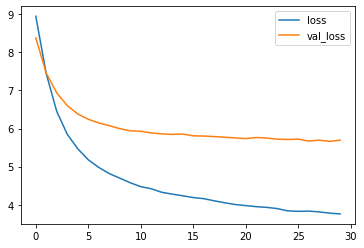

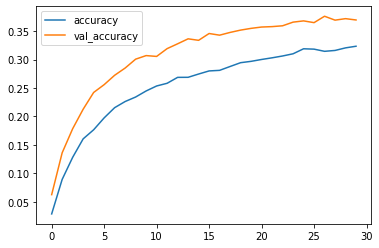

In [ ]:
p = pd.DataFrame(history.history)
p[["loss","val_loss"]].plot()
plt.show()
p[["accuracy","val_accuracy"]].plot()
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Data/Shopee/model2.h5")


In [ ]:
model = keras.models.load_model("/content/drive/My Drive/Data/Shopee/model.h5", custom_objects={'KerasLayer': feature_extractor_layer})

In [11]:
!pip install transformers
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 2.6 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 34.5 MB/s 
     |████████████████████████████████| 636 kB 43.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [12]:
import transformers
import tensorflow_hub as hub
import tokenization
from sklearn.model_selection import train_test_split

In [13]:
def bert_encode(texts,tokenizer, max_len = 512):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in texts:
    text = tokenizer.tokenize(text)

    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]

    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    pad_len = max_len - len(input_sequence)

    tokens += [0]*pad_len
    pad_mask = [1]*len(input_sequence)+[0]*pad_len

    segment_id = [0]*max_len

    all_tokens.append(tokens)
    all_masks.append(pad_mask)
    all_segments.append(segment_id)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [14]:
def build_model(bert_layer,max_len=512):

  input_word_ids = tf.keras.layers.Input(shape=(max_len,),dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_len,),dtype=tf.int32,name="input_mask")
  input_segment_ids = tf.keras.layers.Input(shape=(max_len,),dtype=tf.int32,name="input_segment_ids")

  _,sequence_output = bert_layer([input_word_ids,input_mask,input_segment_ids])
  clf_output = sequence_output[:,0,:]
  #model_X = tf.keras.layers.Dense(100,activation='relu')(clf_output)
  #model_X = tf.keras.layers.BatchNormalization()(model_X)
  #model_X = tf.keras.layers.Dropout(0.3)(model_X)
  #model_X = tf.keras.layers.Dense(100,activation='relu')(model_X)
  #model_X = tf.keras.layers.BatchNormalization()(model_X)
  #model_X = tf.keras.layers.Dropout(0.3)(model_X)
  out = tf.keras.layers.Dense(11014,activation='softmax')(clf_output)

  model = tf.keras.models.Model(inputs=[input_word_ids,input_mask,input_segment_ids],outputs=out)

  return model

In [15]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=False)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1: 1.04GB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.


CPU times: user 36.3 s, sys: 8.79 s, total: 45.1 s
Wall time: 48.2 s


In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train['title'].values,train['label_group'].values,test_size=0.2)
train_input = bert_encode(X_train,tokenizer,max_len=160)
val_input = bert_encode(X_test,tokenizer,max_len=160)
train_labels = y_train.astype('str').astype('int')
val_labels = y_test.astype('str').astype('int')

In [18]:
model = build_model(bert_layer,max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True)

model.compile(optimizer=SGD(learning_rate=0.1),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
train_history = model.fit(
    train_input, train_labels,
    validation_data=(val_input,val_labels),
    epochs=3,
    callbacks=[es],
    batch_size=12
)

Epoch 1/3
2284/2284 [==============================] - 2449s 1s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/3
 585/2284 [======>.......................] - ETA: 24:14 - loss: nan - accuracy: 0.0000e+00

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  object
 5   path         34250 non-null  object
dtypes: object(6)
memory usage: 1.6+ MB
